# Vaccination model

Our goal here is to create a good enough model do describe the COVID-19 pandemic, including vaccination of susceptible individuals. We'll apply compartmental models for persuing our task. In this notebook, we'll develop 2 models. A simple SEVIRD model, which accounts for Susceptible, Exposed, Infected, Recovered and Dead individuals and a modified SEIRD model to include the most simple way to introduce vaccination into an epidemic model.

Before continuing to the description of each model, we will import all of our necessary libraries. We'll be using the standard utilities libraries **numpy** and **matplotlib**, and **scipy** will be used to integrate the system of differential equations.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## SEVIRD model

Our first model is an adaptation simple and wiedly used in mathematical epidemiology. We divide the population into 6 compartments: Susceptible individuals (S), Exposed invidivuals, the ones that have already contracted the virus, but do not show symptoms (E), Vaccinated individuals (V), Infected individuals (I), Recovered individuals (R) and Dead inviduals (D). The set of differential equations describing the dynamics of these populations are:

$$\begin{align}
&\frac{dS}{dt} = - \frac{\beta_I}{N} I S - \frac{\beta_E}{N} E S - \lambda(t) S \\
&\frac{dE}{dt} = \frac{\beta_I}{N} I S + \frac{\beta_E}{N} E S + \frac{\beta_{IV}}{N} I V + \frac{\beta_{EV}}{N} E V - \frac{E}{\tau_e} \\
&\frac{dV}{dt} = \lambda(t) S - \frac{\beta_{IV}}{N} I V - \frac{\beta_{EV}}{N} E V \\
&\frac{dI}{dt} = \frac{E}{\tau_e} - (\gamma + \mu)I \\
&\frac{dR}{dt} = \gamma I \\
&\frac{dD}{dt} = \mu I
\end{align}$$

where $\gamma = (1 - IFR)/\tau_r$, being $IFR$ the Infection Fatality Ratio, representing the percentage of individuals that die upon infection. The same way, $\mu = IFR/\tau_d$. That way, $\gamma$ represents the recovery ration and $\mu$ the death ratio. The parameter $\tau_e$ is the incubation period of COIVD-19. $\beta$ is the infectibility of the disease, $\beta_I$ is the infectibility of susceptible people by infected individuals, $\beta_E$ is the infectibility of susceptible people by exposed inviduals. In the same picture, $\beta_{(I,E)V}$ is the infectibility of vaccinated individuals by those who are infected and exposed. We introduce this term to represent the non-perfect efficacy of COVID-19 vaccines.

Finally, $\lambda(t)$ defines the vaccination rate, which might be a constant function, or a time varying function. Here we define, $\lambda(t)$ as a simple constant function that starts at a given time $t_0$.

For a didatic example, let us set

$$ \lambda(t) = \left\{\begin{matrix}
0 \hspace{1cm} \text{if t} \geq 100\\ 
0.01 \hspace{1cm} \text{if t > 100}
\end{matrix}\right.$$

In [2]:
def λ(t):
    if t <= 100:
        return 0
    elif t > 100:
        return 0.01

Of course you can change $\lambda(t)$ however you see fit. Now we define the function SEVIRD with our set of differential equations and the set of choosen parameters.

In [3]:
def SEVIRD(x, t):
    S = x[0]
    E = x[1]
    V = x[2]
    I = x[3]
    R = x[4]
    D = x[5]
    
    beta_I = 0.2
    beta_E = 0.1
    beta_IV = 0.05*beta_I
    beta_EV = 0.05*beta_E
    tau = 5
    tau_r = 14
    tau_d = 28
    ifr = 0.005
    
    gamma = (1-ifr)/tau_r
    mu = ifr/tau_d
    
    dSdt = -beta_I*I*S/N - beta_E*E*S/N - λ(t)*S
    dEdt = beta_I*I*S/N + beta_E*E*S/N + beta_IV*I*S/N + beta_EV*E*S/N - E/tau
    dVdt = λ(t)*S - beta_IV*I*V/N - beta_EV*E*V/N
    dIdt = E/tau - (gamma + mu)*I
    dRdt = gamma*I
    dDdt = mu*I
    return [dSdt, dEdt, dVdt, dIdt, dRdt, dDdt]

We get now to the integration and numerical solution of these equations, the first step is to define the initial conditions of our epidemic, that is, the total number of inviduals in our population $N$ (usually assumed to be constant), the initial number of infected, exposed, recovered, dead and vaccinated. In our example, let's set $N = 10^6$ individuals and $I_0 = 1$ while $E_0 = R_0 = D_0 = V_0 = 0$.

In [4]:
N = 1e6
I0 = 1
E0 = 0
R0 = 0
D0 = 0
V0 = 0

We then define the range of time for the integration (from 0 to 300 days in our example, feel free to change it) and use **odeint** function from **scipy** library to integrate the SEVIRD model.

In [5]:
x0 = [N,E0,V0,I0,R0,D0]
t = np.linspace(0, 300, 301)
x = odeint(SEVIRD, x0, t)

We select the corresponding variables from the solution $x$ given by **odeint**

In [6]:
S = x[:,0]
E = x[:,1]
V = x[:,2]
I = x[:,3]
R = x[:,4]
D = x[:,5]

And finally, let us plot the curves related to each population of our model.

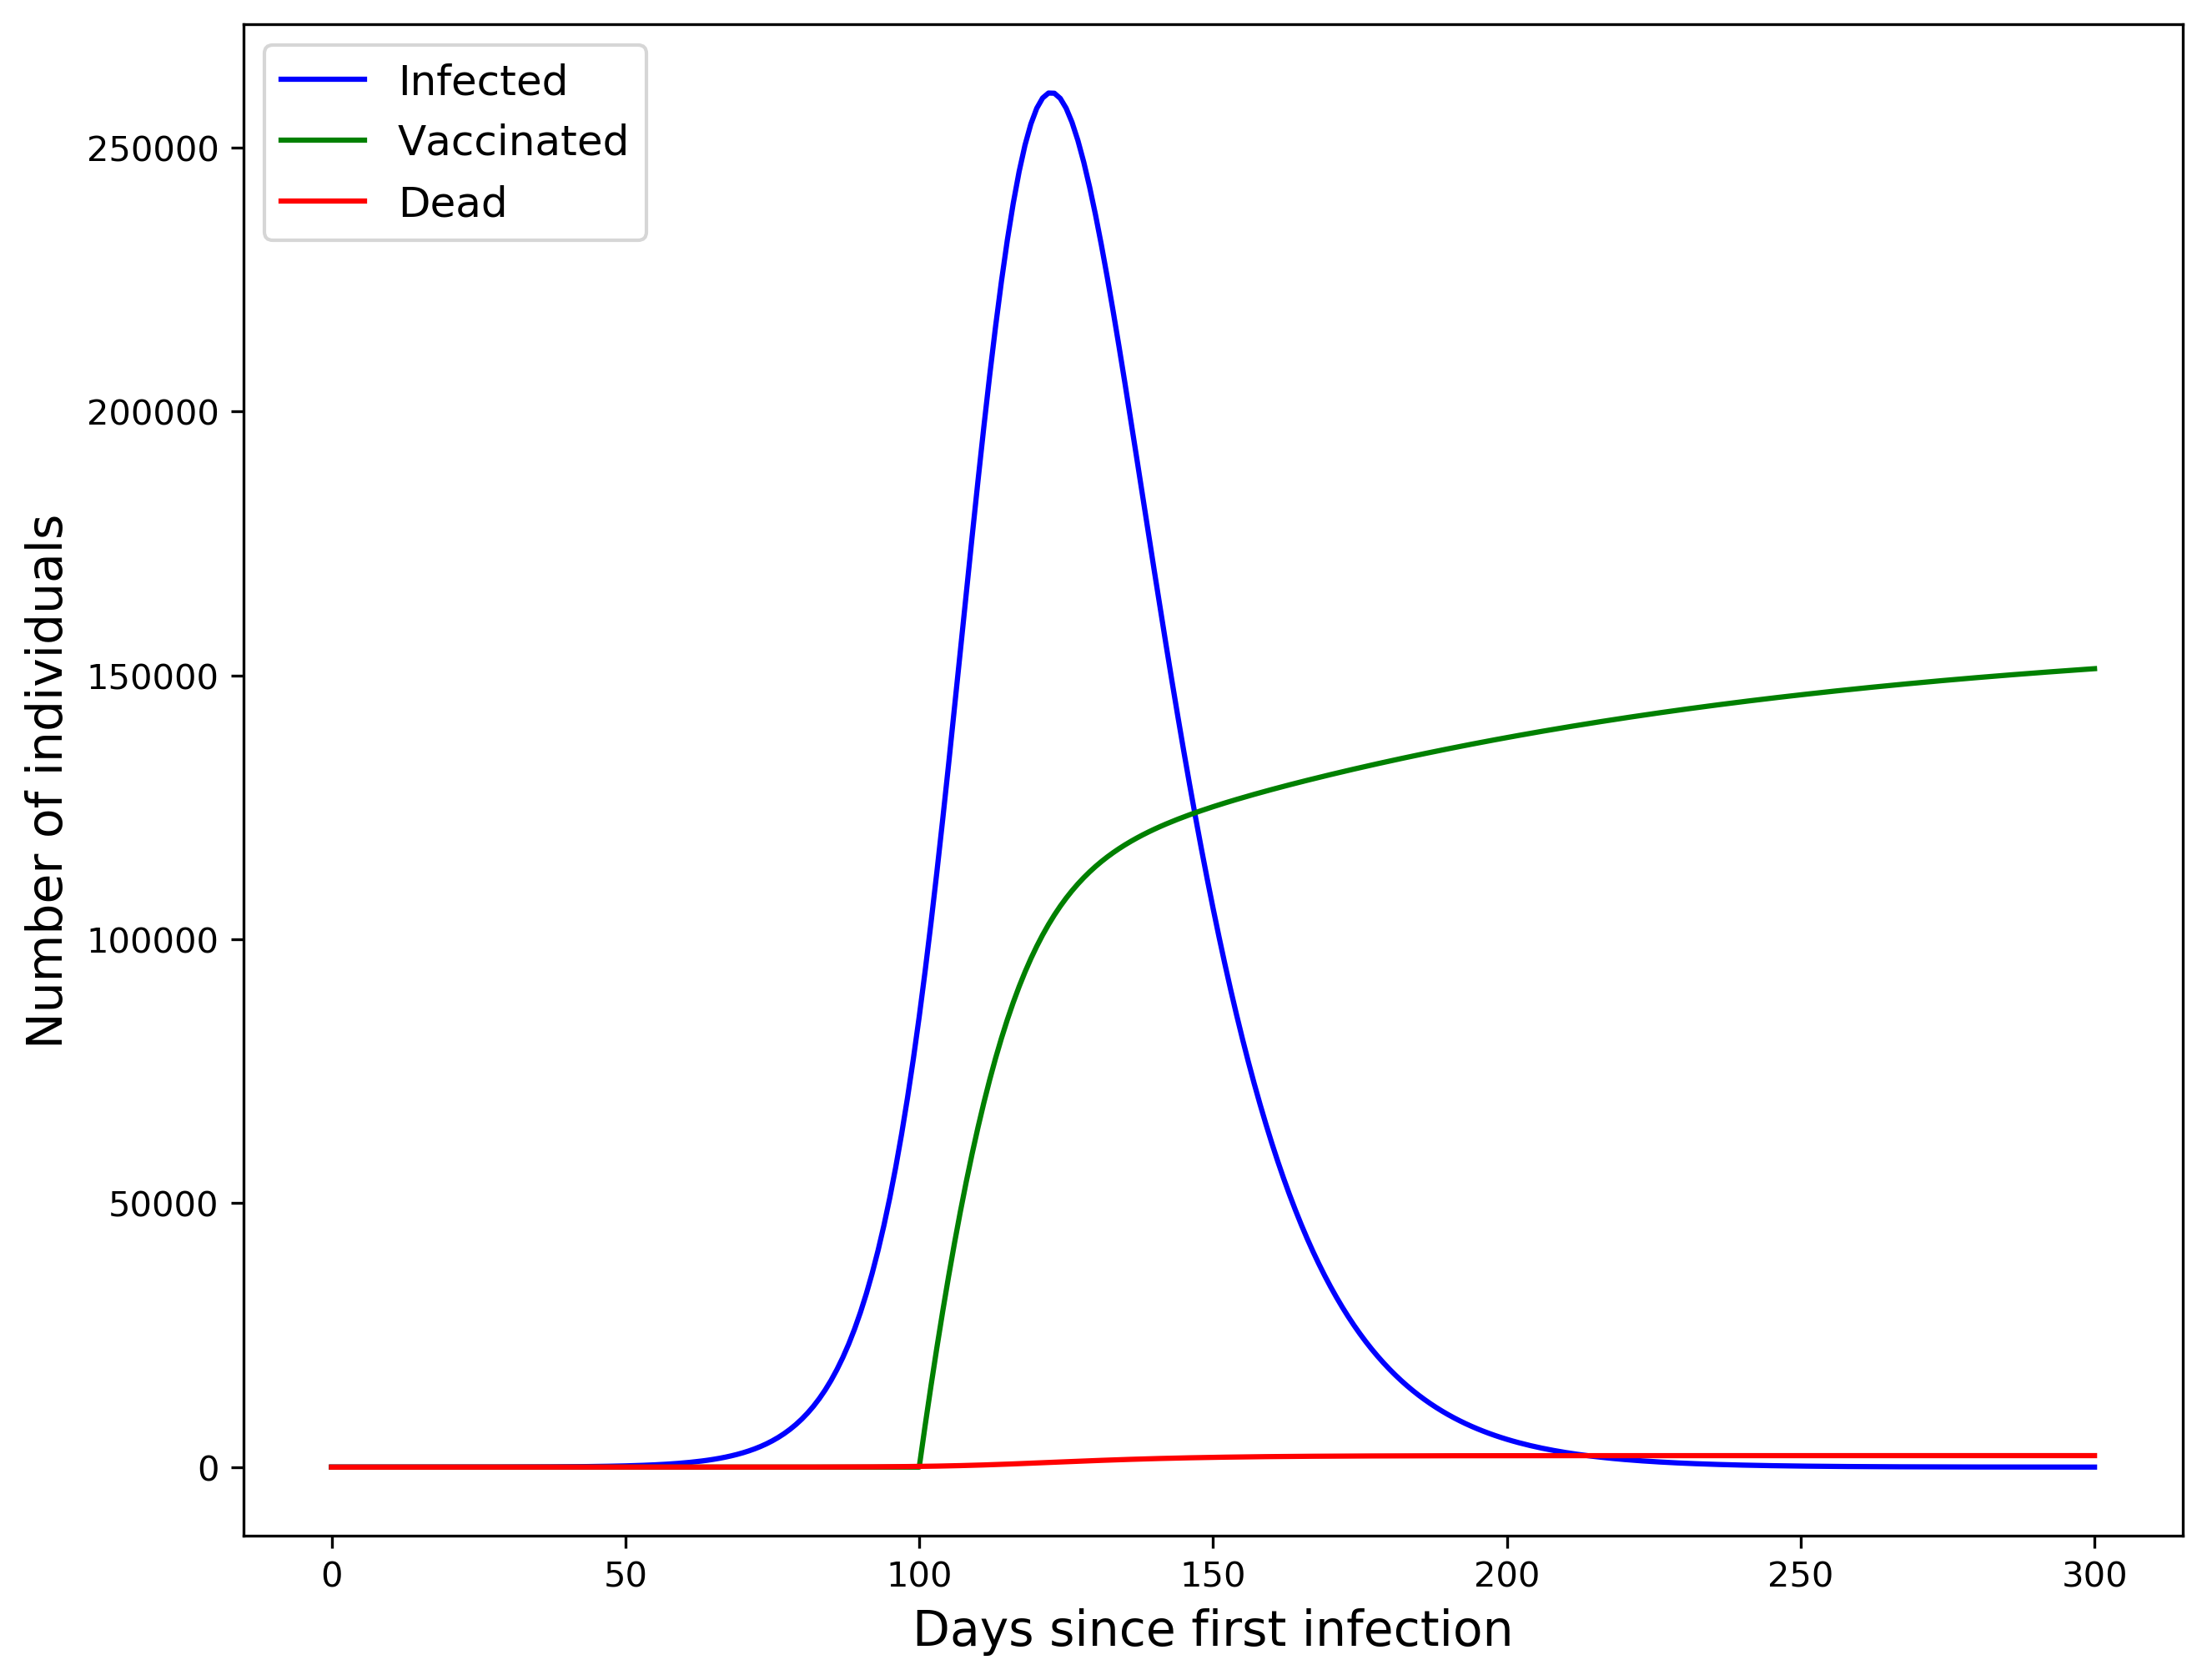

In [7]:
plt.figure(figsize=(10,8), dpi = 300)
plt.plot(t, I, color = 'blue', label = 'Infected')
plt.plot(t, V, color = 'green', label = 'Vaccinated')
plt.plot(t, D, color = 'red', label = 'Dead')
plt.xlabel('Days since first infection', fontsize = 14)
plt.ylabel('Number of individuals', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 12)

The downside of this model is the assumption that only susceptible individuals get vaccinated. A more realistic picture could be drawn considering the possibility of reinfection of recovered inviduals after some time and a vaccination rate $\lambda_s(t)$ for susceptible individuals together with another $\lambda_r(t)$ for recovered individuals, and finally considering the addition of $-R \cdot 1/\tau_{reinf}$ into the recovered population and $R \cdot 1/\tau_{reinf}$ into the susceptible population. In fact, what we observe in the world is the massive vaccination of both susceptible individuals and those who already recovered from the disease, since the immune response elicted by the vaccines is more robust than the one elicted by the disease. The problem with doing this is finding out how long does it take, in average, for people to become susceptible again after recovering, which is still a open question.

## SEIRD model with simple vaccination

The simplest form of including vaccination in an epidemiological model is by modifying the differential equations with the addition of a $\lambda$ term in the equations, removing individuals from the Susceptible population and adding them into the recovered population, which is transformed into a immunized compartment.

$$\begin{align}
&\frac{dS}{dt} = - \frac{\beta_I}{N} I S - \frac{\beta_E}{N} E S - \lambda S \\
&\frac{dE}{dt} = \frac{\beta_I}{N} I S + \frac{\beta_E}{N} E S - \frac{E}{\tau_e} \\
&\frac{dI}{dt} = \frac{E}{\tau_e} - (\gamma + \mu)I \\
&\frac{dR}{dt} = \gamma I + \lambda S \\
&\frac{dD}{dt} = \mu I
\end{align}$$

In an analogy to the last section, we define the modified SEIRD function and solve it the same way.

In [8]:
def λ(t):
    if t <= 100:
        return 0
    elif t > 100:
        return 0.01

In [9]:
def modified_SEIRD(x, t):
    S = x[0]
    E = x[1]
    I = x[2]
    R = x[3]
    D = x[4]
    
    beta_I = 0.3
    beta_E = 0.2
    tau = 5
    tau_r = 14
    tau_d = 28
    ifr = 0.005
    
    gamma = (1-ifr)/tau_r
    mu = ifr/tau_d
    
    dSdt = -beta_I*I*S/N - beta_E*E*S/N - λ(t)*S
    dEdt = beta_I*I*S/N + beta_E*E*S/N - E/tau
    dIdt = E/tau - (gamma + mu)*I
    dRdt = gamma*I + λ(t)*S
    dDdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [10]:
N = 1e6
I0 = 1
E0 = 0
R0 = 0
D0 = 0

In [11]:
x0 = [N,E0,I0,R0,D0]
t = np.linspace(0, 300, 301)
x = odeint(modified_SEIRD, x0, t)

In [12]:
S = x[:,0]
E = x[:,1]
I = x[:,2]
R = x[:,3]
D = x[:,4]

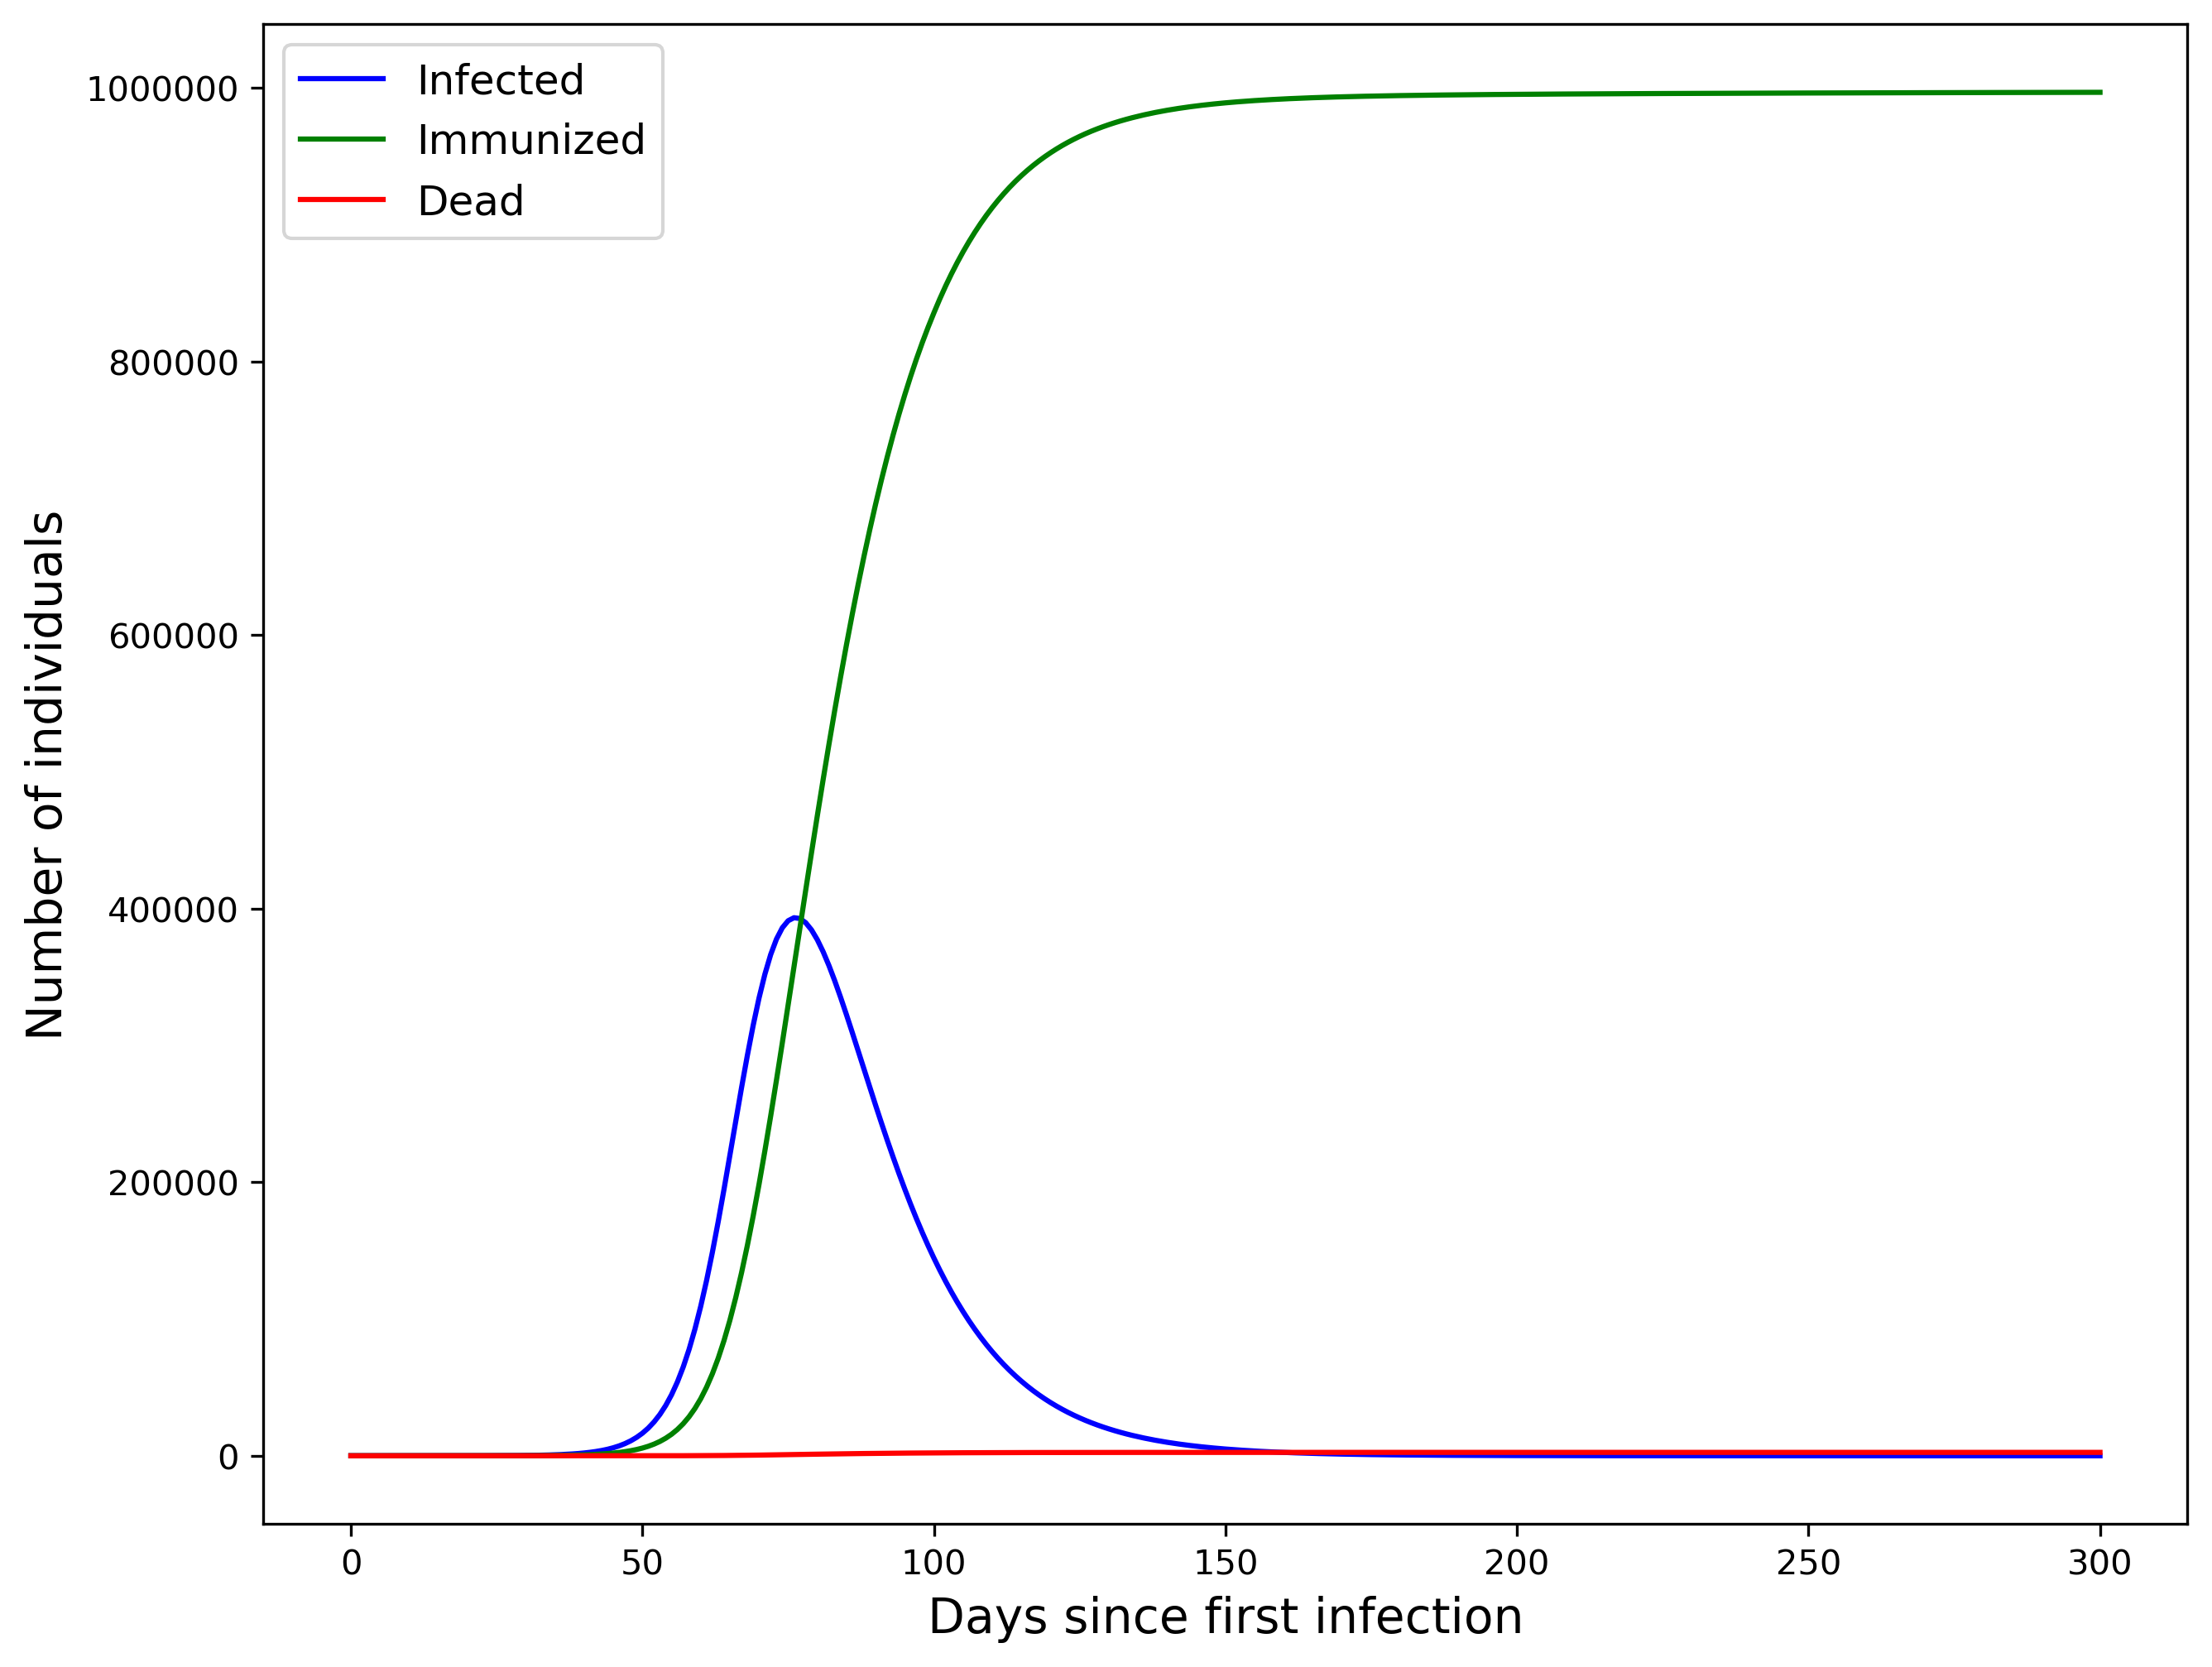

In [13]:
plt.figure(figsize=(10,8), dpi = 300)
plt.plot(t, I, color = 'blue', label = 'Infected')
plt.plot(t, R, color = 'green', label = 'Immunized')
plt.plot(t, D, color = 'red', label = 'Dead')
plt.xlabel('Days since first infection', fontsize = 14)
plt.ylabel('Number of individuals', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 12)

The donwside of this model is, in our opinion, the lack of specific information regarding the vaccinated population and the assumption that both recovered individuals and vaccinated individuals belong in the same category of immunization.